In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import time


In [3]:
def set_seeds():
    # set random seed value
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
    # Fix seed to make training deterministic.
    if torch.cuda.is_available():
       torch.cuda.manual_seed(SEED_VALUE)
       torch.cuda.manual_seed_all(SEED_VALUE)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = True

set_seeds()

In [4]:
#Convert to Tensors and Normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # mean, std
])

# Download and load the training data
train_set = datasets.FashionMNIST(root = "F_MNIST_data", download = True, train = True, transform = transform)
val_set = datasets.FashionMNIST(root = "F_MNIST_data", download = True, train = False, transform = transform) #Test set

print("Total Train Images: ", len(train_set))
print("Total Val Images: ", len(val_set))

100%|██████████| 26.4M/26.4M [00:04<00:00, 6.52MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 283kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.68MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 592kB/s]


Total Train Images:  60000
Total Val Images:  10000


In [5]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle = True, batch_size = 64)
val_loader = torch.utils.data.DataLoader(val_set, shuffle = False, batch_size = 64)

In [6]:
#class to idx mapping
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"  }

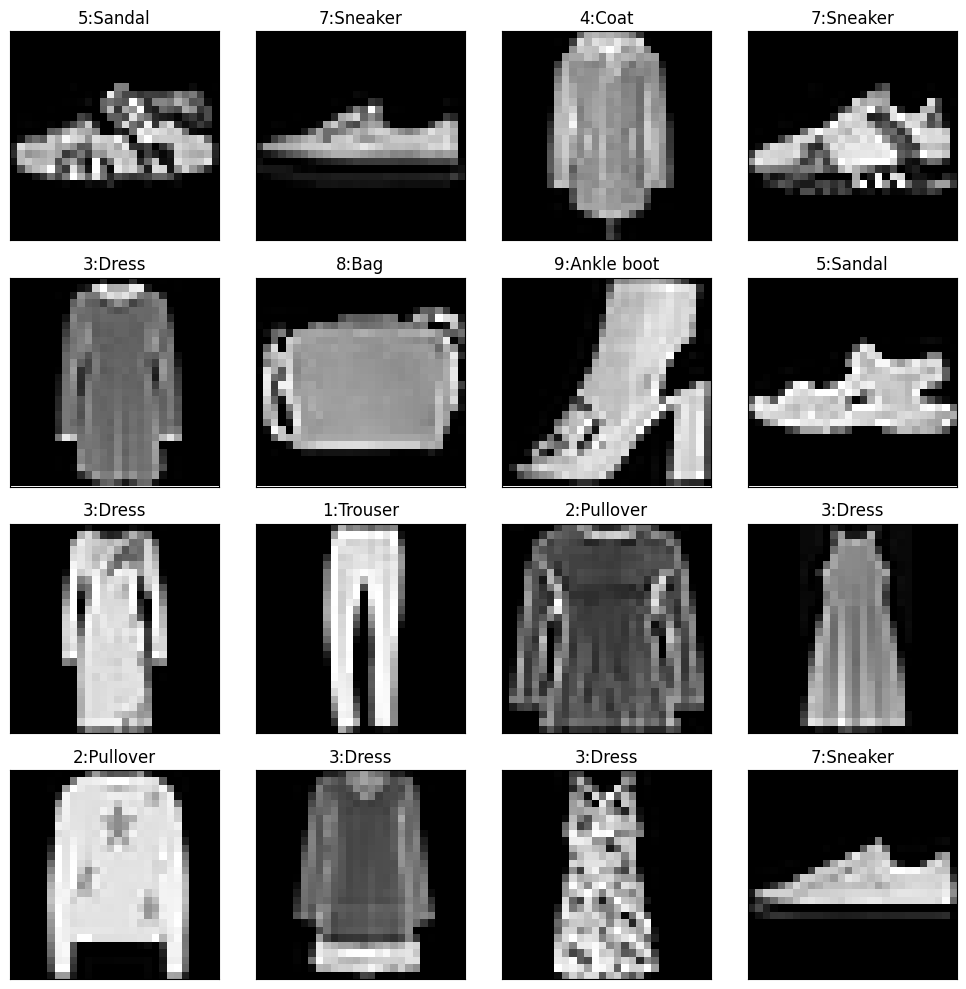

In [7]:
def visualize_images(trainloader, num_images=20):
    fig = plt.figure(figsize=(10, 10))

    # Iterate over the first batch
    images, labels = next(iter(trainloader))

    #To calculate the number of rows and columns for subplots
    num_rows = 4
    num_cols = int(np.ceil(num_images / num_rows))

    for idx in range(min(num_images, len(images))):
      image, label = images[idx], labels[idx]

      ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(image), cmap="gray")
      ax.set_title(f"{label.item()}:{class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images=16)

MLP Model Implementation

In [9]:
class MLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc0 = nn.Linear(784, 512)
        self.bn0 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64,num_classes)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        #Flatten the input tensor
        x = x.view(x.shape[0], -1) #(B,784)  --> 28x28 = 784
        # First fully connected layer with ReLU, batch norm, and dropout
        x = F.relu(self.bn0(self.fc0(x)))
        x = self.dropout(x)

        x = F.relu(self.bn1(self.fc1(x)))

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        # Output layer with softmax activation
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim = 1)


        return x
    
# Instantiate the model.
mlp_model = MLP(num_classes = 10)

In [10]:
#A dummy input size of (B,C,H,W) = (1,1,28,28) is passed.
print(summary(mlp_model, input_size = (1,1,28,28), row_settings = ["var_names"]))
# Display the model summary.

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Dropout (dropout)                      [1, 128]                  --
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

Training configuration

In [11]:
criterion = F.nll_loss #Negative Log Likelihood Loss
optimizer = optim.Adam(mlp_model.parameters(), lr = 1e-2) #0.01
num_epochs = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Model Training

In [ ]:
def train(model, trainloader, criterion, optimizer, DEVICE):
    model.train()
    model.to(DEVICE)
    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images, labels in trainloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy